## Network Intrusion Detection

In [1]:
import pandas as pd
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [2]:
data=pd.read_csv('Network.csv')
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
data.shape

(25192, 42)

In [4]:
class_counts = data['class'].value_counts()

print(class_counts)

class
normal     13449
anomaly    11743
Name: count, dtype: int64


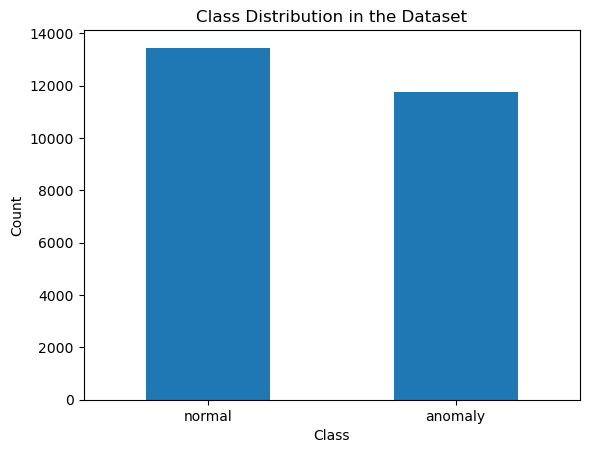

In [5]:
import matplotlib.pyplot as plt
class_counts.plot(kind='bar', rot=0)
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [6]:
import findspark
findspark.init()

In [7]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession

In [8]:
conf = SparkConf().setAppName("Example")
sc = SparkContext(conf=conf)

24/01/06 19:31:08 WARN Utils: Your hostname, Ravis-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.29.245 instead (on interface en0)
24/01/06 19:31:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/06 19:31:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/06 19:31:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/06 19:31:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [9]:
spark = SparkSession.builder.appName("StringIndexerExample").getOrCreate()


In [10]:
column_names = data.columns.tolist()
column_names

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'class']

## Percentage Of Zeros in Each Column

In [11]:
zero_percentage = (data == 0).mean() * 100
print("Percentage of Zero Values in Each Column:")
print(zero_percentage)


Percentage of Zero Values in Each Column:
duration                        91.965703
protocol_type                    0.000000
service                          0.000000
flag                             0.000000
src_bytes                       39.163226
dst_bytes                       53.882185
land                            99.992061
wrong_fragment                  99.110829
urgent                          99.996030
hot                             97.935853
num_failed_logins               99.908701
logged_in                       60.523182
num_compromised                 98.920292
root_shell                      99.845189
su_attempted                    99.916640
num_root                        99.468085
num_file_creations              99.738012
num_shells                      99.964274
num_access_files                99.686408
num_outbound_cmds              100.000000
is_host_login                  100.000000
is_guest_login                  99.087012
count                            0

## STRING INDEXER

In [12]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline


In [13]:
df = spark.createDataFrame(data, column_names)


columns_to_index = ["protocol_type", "service", "flag",'class']

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip") for col in columns_to_index]

assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCol="features")

pipeline = Pipeline(stages=indexers + [assembler])

indexed_data = pipeline.fit(df).transform(df)
indexed_data.select("protocol_type", "service", "flag",'class',"protocol_type_index", "service_index", "flag_index",'class_index', "features").show(truncate=False)



24/01/06 19:31:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/01/06 19:31:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------------+----------+----+-------+-------------------+-------------+----------+-----------+------------------+
|protocol_type|service   |flag|class  |protocol_type_index|service_index|flag_index|class_index|features          |
+-------------+----------+----+-------+-------------------+-------------+----------+-----------+------------------+
|tcp          |ftp_data  |SF  |normal |0.0                |4.0          |0.0       |0.0        |(4,[1],[4.0])     |
|udp          |other     |SF  |normal |1.0                |6.0          |0.0       |0.0        |[1.0,6.0,0.0,0.0] |
|tcp          |private   |S0  |anomaly|0.0                |1.0          |1.0       |1.0        |[0.0,1.0,1.0,1.0] |
|tcp          |http      |SF  |normal |0.0                |0.0          |0.0       |0.0        |(4,[],[])         |
|tcp          |http      |SF  |normal |0.0                |0.0          |0.0       |0.0        |(4,[],[])         |
|tcp          |private   |REJ |anomaly|0.0                |1.0          

In [14]:
columns_to_drop = ["protocol_type", "service", "flag",'class','features']

indexed_data  = indexed_data .drop(*columns_to_drop)

indexed_data.show(5)


+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------------+-------------+----------+-----------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_cou

## Label and Data Division 

In [15]:
features = indexed_data.drop(*['class_index']) 
labels = indexed_data['class_index']      

print("Features:")
print(features)

print("\nLabels:")
print(labels)

Features:
DataFrame[duration: bigint, src_bytes: bigint, dst_bytes: bigint, land: bigint, wrong_fragment: bigint, urgent: bigint, hot: bigint, num_failed_logins: bigint, logged_in: bigint, num_compromised: bigint, root_shell: bigint, su_attempted: bigint, num_root: bigint, num_file_creations: bigint, num_shells: bigint, num_access_files: bigint, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: bigint, count: bigint, srv_count: bigint, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: bigint, dst_host_srv_count: bigint, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, protocol_type_index: double, service_index: double, flag_ind

## Train-Test Split

In [16]:
train_data, test_data =indexed_data .randomSplit([0.8, 0.2], seed=42)


In [17]:
labels_train =train_data ['class_index']  
features_train = train_data.drop('class_index') 
    

print("Features:")
print(features_train)

print("\nLabels:")
print(labels_train)

Features:
DataFrame[duration: bigint, src_bytes: bigint, dst_bytes: bigint, land: bigint, wrong_fragment: bigint, urgent: bigint, hot: bigint, num_failed_logins: bigint, logged_in: bigint, num_compromised: bigint, root_shell: bigint, su_attempted: bigint, num_root: bigint, num_file_creations: bigint, num_shells: bigint, num_access_files: bigint, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: bigint, count: bigint, srv_count: bigint, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: bigint, dst_host_srv_count: bigint, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, protocol_type_index: double, service_index: double, flag_ind

In [18]:
labels_test =test_data ['class_index']  
features_test = test_data.drop('class_index') 
    

print("Features:")
print(features_test)

print("\nLabels:")
print(labels_test)

Features:
DataFrame[duration: bigint, src_bytes: bigint, dst_bytes: bigint, land: bigint, wrong_fragment: bigint, urgent: bigint, hot: bigint, num_failed_logins: bigint, logged_in: bigint, num_compromised: bigint, root_shell: bigint, su_attempted: bigint, num_root: bigint, num_file_creations: bigint, num_shells: bigint, num_access_files: bigint, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: bigint, count: bigint, srv_count: bigint, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: bigint, dst_host_srv_count: bigint, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, protocol_type_index: double, service_index: double, flag_ind

## Classification

In [19]:
feature_cols=['duration',
 'protocol_type_index',
 'service_index',
 'flag_index',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',]

## Vector Assembler

In [20]:
feature_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

## Random Forest

In [21]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator


In [22]:
rf_classifier = RandomForestClassifier(labelCol="class_index", featuresCol="features", maxBins=100)
pipeline = Pipeline(stages=[feature_assembler, rf_classifier])

train_data, test_data = indexed_data.randomSplit([0.7, 0.3], seed=42)

model = pipeline.fit(train_data)

rf_predictions = model.transform(test_data)

In [23]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [24]:
accuracy_rf=evaluator.evaluate(rf_predictions,{evaluator.metricName:"accuracy"})
precision_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"weightedPrecision"})
recall_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"weightedRecall"})
f1_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"f1"})
table_rf= [("Accuracy", accuracy_rf*100), ("Precision", precision_rf*100), ("Recall", recall_rf*100), ("F1-Score", f1_rf*100)]
table_df_rf = pd.DataFrame(table_rf, columns=["Metric", "Value"])
table_df_rf

,Metric,Value
0,Accuracy,98.638997
1,Precision,98.655902
2,Recall,98.638997
3,F1-Score,98.637816


Area Under ROC (AUC): 0.9993007091632639


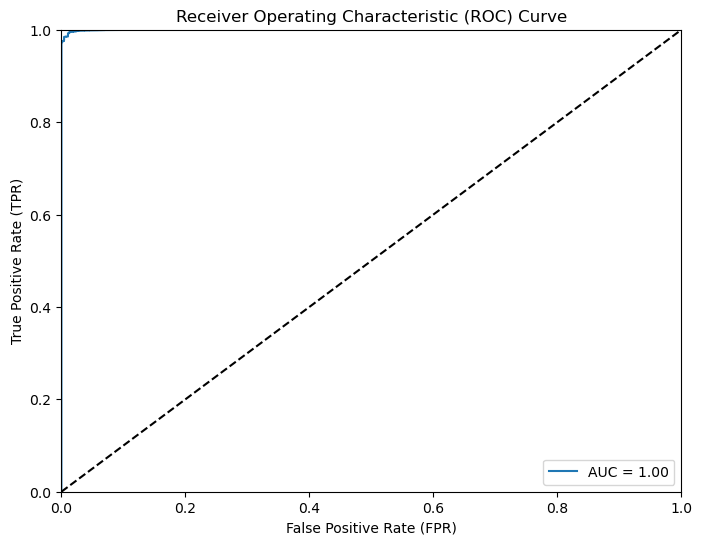

In [25]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
import numpy as np

evaluator_roc = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="class_index", metricName="areaUnderROC")
roc_auc = evaluator_roc.evaluate(rf_predictions)
print("Area Under ROC (AUC):", roc_auc)

# Plot ROC Curve
roc = model.stages[-1].summary.roc.toPandas()
plt.figure(figsize=(8, 6))
plt.plot(roc['FPR'], roc['TPR'], label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## SVM

In [26]:
from pyspark.ml.classification import LinearSVC


In [27]:
svm = LinearSVC(labelCol="class_index", featuresCol="features")
pipeline = Pipeline(stages=[feature_assembler, svm])
model = pipeline.fit(train_data)

svm_predictions = model.transform(test_data)

24/01/06 19:31:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/06 19:31:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [28]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [29]:
accuracy_svm=evaluator.evaluate(svm_predictions,{evaluator.metricName:"accuracy"})
precision_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"weightedPrecision"})
recall_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"weightedRecall"})
f1_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"f1"})
table_svm= [("Accuracy", accuracy_svm*100), ("Precision", precision_svm*100), ("Recall", recall_svm*100), ("F1-Score", f1_svm*100)]
table_df_svm = pd.DataFrame(table_svm, columns=["Metric", "Value"])
table_df_svm

,Metric,Value
0,Accuracy,95.351031
1,Precision,95.366708
2,Recall,95.351031
3,F1-Score,95.346243


## Naive Bayes

In [30]:
from pyspark.ml.classification import NaiveBayes


In [31]:
naive_bayes = NaiveBayes(labelCol='class_index', featuresCol='features' )
pipeline = Pipeline(stages=[feature_assembler, naive_bayes])
model = pipeline.fit(train_data)

predictions = model.transform(test_data)

In [32]:
evaluator=MulticlassClassificationEvaluator(labelCol="class_index",predictionCol="prediction")

In [33]:
accuracy_nb=evaluator.evaluate(predictions,{evaluator.metricName:"accuracy"})
precision_nb = evaluator.evaluate(predictions,{evaluator.metricName:"weightedPrecision"})
recall_nb = evaluator.evaluate(predictions,{evaluator.metricName:"weightedRecall"})
f1_nb = evaluator.evaluate(predictions,{evaluator.metricName:"f1"})
table= [("Accuracy", accuracy_nb*100), ("Precision", precision_nb*100), ("Recall", recall_nb*100), ("F1-Score", f1_nb*100)]
table_df = pd.DataFrame(table, columns=["Metric", "Value"])
table_df

,Metric,Value
0,Accuracy,83.560167
1,Precision,84.528930
2,Recall,83.560167
3,F1-Score,83.562684


## Decision Tree

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier


In [35]:
tree= DecisionTreeClassifier(labelCol="class_index", featuresCol="features", maxBins=100)
pipeline = Pipeline(stages=[feature_assembler, tree])
model = pipeline.fit(train_data)

tree_predictions = model.transform(test_data)

In [36]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [37]:

accuracy_tree=evaluator.evaluate(tree_predictions,{evaluator.metricName:"accuracy"})
precision_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"weightedPrecision"})
recall_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"weightedRecall"})
f1_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"f1"})
table_tree= [("Accuracy", accuracy_tree*100), ("Precision", precision_tree*100), ("Recall", recall_tree*100), ("F1-Score", f1_tree*100)]
table_df_tree = pd.DataFrame(table_tree, columns=["Metric", "Value"])
table_df_tree

,Metric,Value
0,Accuracy,98.261690
1,Precision,98.268377
2,Recall,98.261690
3,F1-Score,98.260715


## MLP

In [38]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [39]:
layers = [len(feature_assembler.getInputCols()), 64, 32, 2]
mlp_classifier = MultilayerPerceptronClassifier(layers=layers, seed=1234, labelCol="class_index", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[feature_assembler, mlp_classifier])
model = pipeline.fit(train_data)

mlp_predictions = model.transform(test_data)


In [40]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [41]:
accuracy_mlp=evaluator.evaluate(mlp_predictions,{evaluator.metricName:"accuracy"})
precision_mlp = evaluator.evaluate(mlp_predictions,{evaluator.metricName:"weightedPrecision"})
recall_mlp = evaluator.evaluate(mlp_predictions,{evaluator.metricName:"weightedRecall"})
f1_mlp= evaluator.evaluate(mlp_predictions,{evaluator.metricName:"f1"})
table_mlp= [("Accuracy", accuracy_mlp*100), ("Precision", precision_mlp*100), ("Recall", recall_mlp*100), ("F1-Score", f1_mlp*100)]
table_df_mlp = pd.DataFrame(table_mlp, columns=["Metric", "Value"])
table_df_mlp

,Metric,Value
0,Accuracy,96.348201
1,Precision,96.375110
2,Recall,96.348201
3,F1-Score,96.343622


## plots

In [42]:
import matplotlib.pyplot as plt

In [43]:
classifiers = ['Naive Bayes','SVM','Decision Tree' ,'Random Forest','MLP']

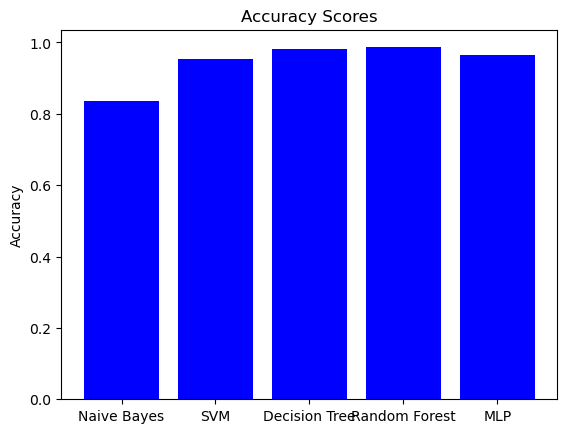

In [44]:
accuracy_scores = [accuracy_nb,accuracy_svm,accuracy_tree,accuracy_rf,accuracy_mlp]
plt.bar( classifiers,accuracy_scores , color='blue')
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

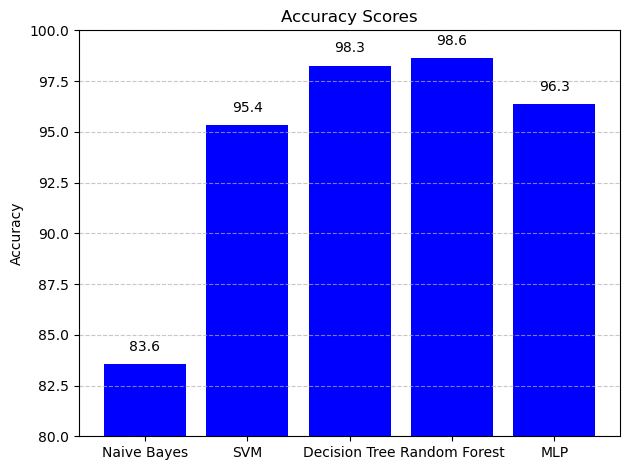

In [53]:
import matplotlib.pyplot as plt

# Sample data
classifiers = ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest', 'MLP']
accuracy_scores = [accuracy_nb*100, accuracy_svm*100, accuracy_tree*100, accuracy_rf*100, accuracy_mlp*100]

# Create a bar plot
plt.bar(classifiers, accuracy_scores, color='blue')
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')

# Set the y-axis range from 60 to 100
plt.ylim(80, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels with higher precision on top of each bar
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.5, f'{score:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


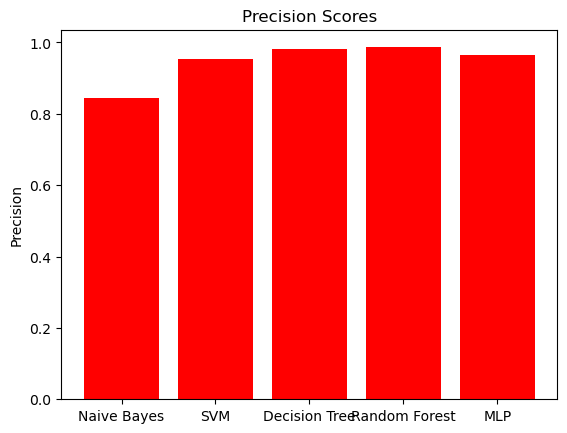

In [46]:
Precision_scores =[precision_nb,precision_svm,precision_tree,precision_rf,precision_mlp]
plt.bar( classifiers,Precision_scores , color='red')
plt.title('Precision Scores')
plt.ylabel('Precision')
plt.show()

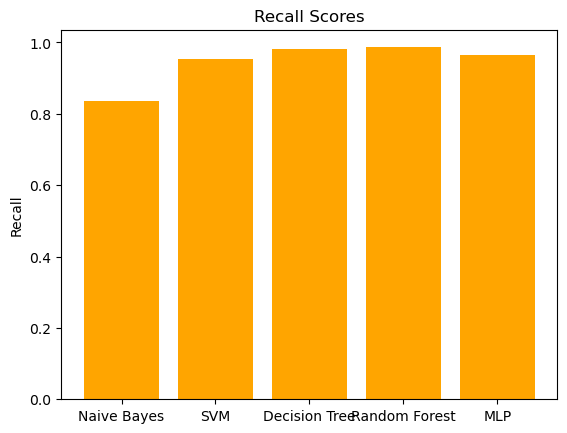

In [47]:
Recall_scores = [recall_nb,recall_svm,recall_tree,recall_rf,precision_mlp]
plt.bar( classifiers,Recall_scores , color='orange')
plt.title('Recall Scores')
plt.ylabel('Recall')
plt.show()

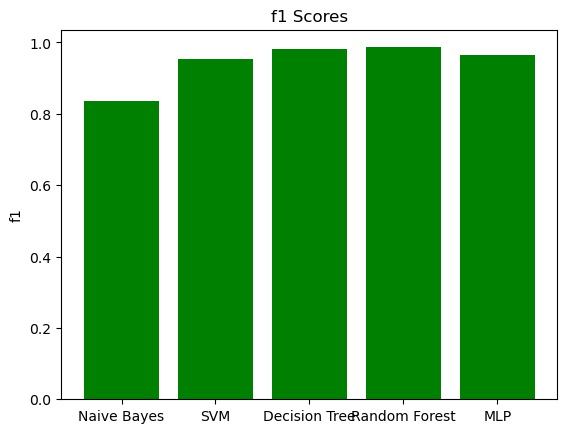

In [48]:
f1_scores = [f1_nb,f1_svm,f1_tree,f1_rf,f1_mlp]
plt.bar( classifiers,f1_scores , color='green')
plt.title('f1 Scores')
plt.ylabel('f1')
plt.show()

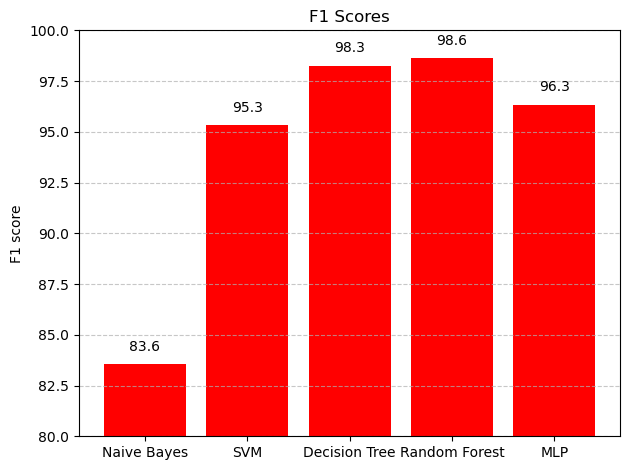

In [54]:
import matplotlib.pyplot as plt

# Sample data
classifiers = ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest', 'MLP']
f1_scores=[f1_nb*100,f1_svm*100,f1_tree*100,f1_rf*100,f1_mlp*100]
# Create a bar plot
plt.bar(classifiers, f1_scores, color='red')
plt.title('F1 Scores')
plt.ylabel('F1 score')

# Set the y-axis range from 60 to 100
plt.ylim(80, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels with higher precision on top of each bar
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.5, f'{score:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [50]:
print("Testing Performances for Machine Learning Algorithms")
result = pd.DataFrame({"Algorithms": ["Naive Bayes","SVM","Decision Tree" ,"Random Forest","MLP"],
                       "Accuracy":[accuracy_nb,accuracy_svm,accuracy_tree,accuracy_rf,accuracy_mlp],
                       "Precision":[precision_nb,precision_svm,precision_tree,precision_rf,precision_mlp],
                       "Recall":[recall_nb,recall_svm,recall_tree,recall_rf,recall_mlp],
                       "F1 Score":[f1_nb,f1_svm,f1_tree,f1_rf,f1_mlp]}).set_index('Algorithms')
result*100

Testing Performances for Machine Learning Algorithms


,Accuracy,Precision,Recall,F1 Score
Algorithms,,,,
Naive Bayes,83.560167,84.528930,83.560167,83.562684
SVM,95.351031,95.366708,95.351031,95.346243
Decision Tree,98.261690,98.268377,98.261690,98.260715
Random Forest,98.638997,98.655902,98.638997,98.637816
MLP,96.348201,96.375110,96.348201,96.343622
